<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/tinnet_O_ALIGNN_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alignn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 40.8 MB/s eta 0:00:00
  Attempting unins

Obtaining TinNet Oxygen dataset 747...
Reference:https://github.com/hlxin/tinnet


100%|██████████| 112k/112k [00:00<00:00, 148kiB/s]


Loading the zipfile...
Loading completed.


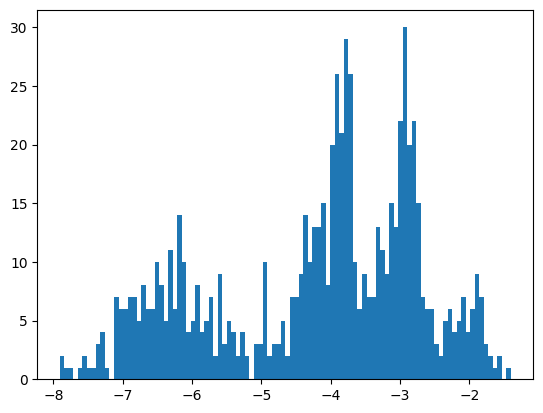

In [2]:
from jarvis.db.figshare import data
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
dfO=pd.DataFrame(data('tinnet_O'))

plt.hist(dfO['ead'],bins=100)
plt.show()

In [3]:
from jarvis.core.atoms import Atoms
def remove_atom(atoms=[],exclude_elements=['O']):
    coords=[]
    elements=[]
    for i,j in zip(atoms.elements,atoms.cart_coords):
        if i not in exclude_elements:
            elements.append(i)
            coords.append(j)

    atoms=Atoms(lattice_mat=atoms.lattice_mat,elements=elements,coords=coords,cartesian=True)
    return atoms

In [7]:
from alignn.ff.ff import AlignnAtomwiseCalculator, default_path,wt1_path

# torch.cuda.is_available = lambda : False
model_path = wt1_path()
calculator = AlignnAtomwiseCalculator(path=model_path, stress_wt=0.3)
def atom_to_energy(atoms):
    num_atoms = atoms.num_atoms
    atoms = atoms.ase_converter()
    atoms.calc = calculator
    forces = atoms.get_forces()
    energy = atoms.get_potential_energy()
    stress = atoms.get_stress()
    return energy   # ,forces,stress

model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_wt1


In [11]:
x=[]
y=[]
for i,ii in dfO.iterrows():
  all_atoms=Atoms.from_dict(ii['atoms'])
  surface=remove_atom(atoms=all_atoms)
  e_all_atoms=atom_to_energy(all_atoms)
  e_surface=atom_to_energy(surface)
  e_ad=e_all_atoms-e_surface
  x.append(e_ad)
  y.append(ii['ead'])

  print(ii['ead'],e_ad)

-1.8254639999979076 -1.2465798258781433
-1.9182199999997351 2.750575065612793
-1.7821859999968979 -0.43939805030822754
-1.8943390000023896 1.47965669631958
-2.184627999999236 0.6731729507446289
-1.821454999994046 2.7227044105529785
-1.9355589999997278 2.407111167907715
-2.493593999999746 -0.29617881774902344
-4.285004000001379 -2.950474262237549
-6.507043999998302 -2.14947509765625
-6.53968900000126 -3.100719451904297
-3.035554000002037 -2.785258650779724
-3.5559219999997254 -1.1187124252319336
-3.348727000000679 -1.4110205173492432
-4.714535000002968 -2.4592228531837463
-4.972342000001106 -2.081483840942383
-4.978187000004425 -2.496657609939575
-5.004773000000739 -2.68373966217041
-4.41008299999902 -1.8925325870513916
-4.527690999999493 -1.7877435684204102
-4.2285429999976145 -0.1926032304763794
-4.310185999998964 -1.286315679550171
-4.223728999999537 1.4214332103729248
-3.778336999999908 0.5558443069458008
-3.9015800000017293 1.7368614673614502
-3.919226000000151 0.8073415756225586
-

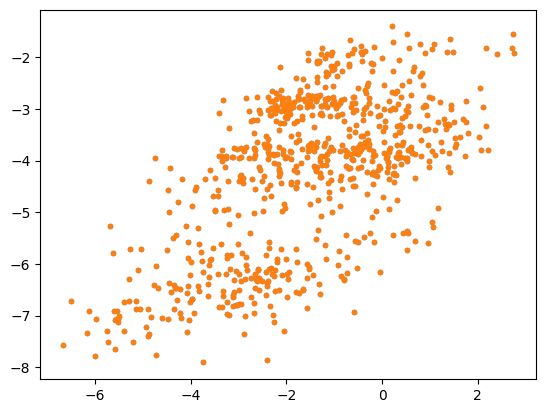

In [13]:
%matplotlib inline
plt.plot(x,y,'.')
plt.show()

In [14]:
len(x)

747

In [37]:
from sklearn.metrics import mean_absolute_error
import numpy as np
mean_absolute_error(y,np.array(x)-2.6)

1.2333945674293305